In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

## CatBoost 진행
1. 랜덤 언더 샘플링 데이터
2. SMOTE-NC 데이터
3. SMOTE-NC + 랜덤 언더 샘플링 데이터
4. 가중치

모델링 과정은 기본 파라미터로 일단 진행됨.

### 1. 랜덤 언더 샘플링 데이터로 CAT 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [2]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/randomunder_modeling/train.csv")
val = pd.read_csv("data/train/randomunder_modeling/val.csv")
test = pd.read_csv("data/train/randomunder_modeling/test.csv")

CatBoost 학습

In [5]:
from catboost import CatBoostClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 기본값을 사용한 CatBoost 모델 생성
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

# 모델 학습
cat_model.fit(X_train, y_train)

0:	learn: 0.6821247	total: 167ms	remaining: 2m 47s
1:	learn: 0.6715755	total: 184ms	remaining: 1m 31s
2:	learn: 0.6620353	total: 196ms	remaining: 1m 5s
3:	learn: 0.6538430	total: 205ms	remaining: 51s
4:	learn: 0.6458405	total: 215ms	remaining: 42.7s
5:	learn: 0.6383018	total: 227ms	remaining: 37.6s
6:	learn: 0.6322623	total: 239ms	remaining: 33.9s
7:	learn: 0.6258234	total: 251ms	remaining: 31.1s
8:	learn: 0.6202663	total: 263ms	remaining: 28.9s
9:	learn: 0.6148839	total: 275ms	remaining: 27.2s
10:	learn: 0.6089921	total: 285ms	remaining: 25.6s
11:	learn: 0.6041246	total: 294ms	remaining: 24.2s
12:	learn: 0.5993574	total: 309ms	remaining: 23.4s
13:	learn: 0.5951854	total: 323ms	remaining: 22.8s
14:	learn: 0.5909998	total: 338ms	remaining: 22.2s
15:	learn: 0.5875800	total: 352ms	remaining: 21.7s
16:	learn: 0.5844217	total: 367ms	remaining: 21.2s
17:	learn: 0.5804682	total: 378ms	remaining: 20.6s
18:	learn: 0.5774679	total: 387ms	remaining: 20s
19:	learn: 0.5745129	total: 401ms	remaining

Validation Accuracy: 0.80

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89   1941849
           1       0.02      0.72      0.05     13252

    accuracy                           0.80   1955101
   macro avg       0.51      0.76      0.47   1955101
weighted avg       0.99      0.80      0.88   1955101


Confusion Matrix (Validation):
[[1549790  392059]
 [   3748    9504]]


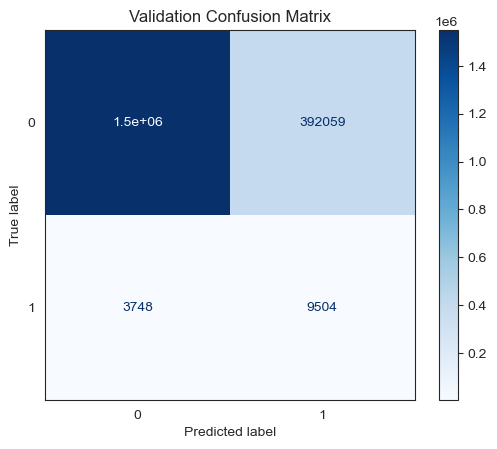

Validation AUC-ROC: 0.84


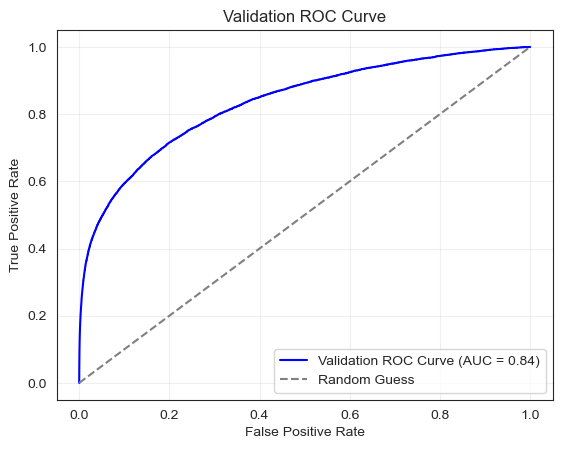

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = cat_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cat_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = cat_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


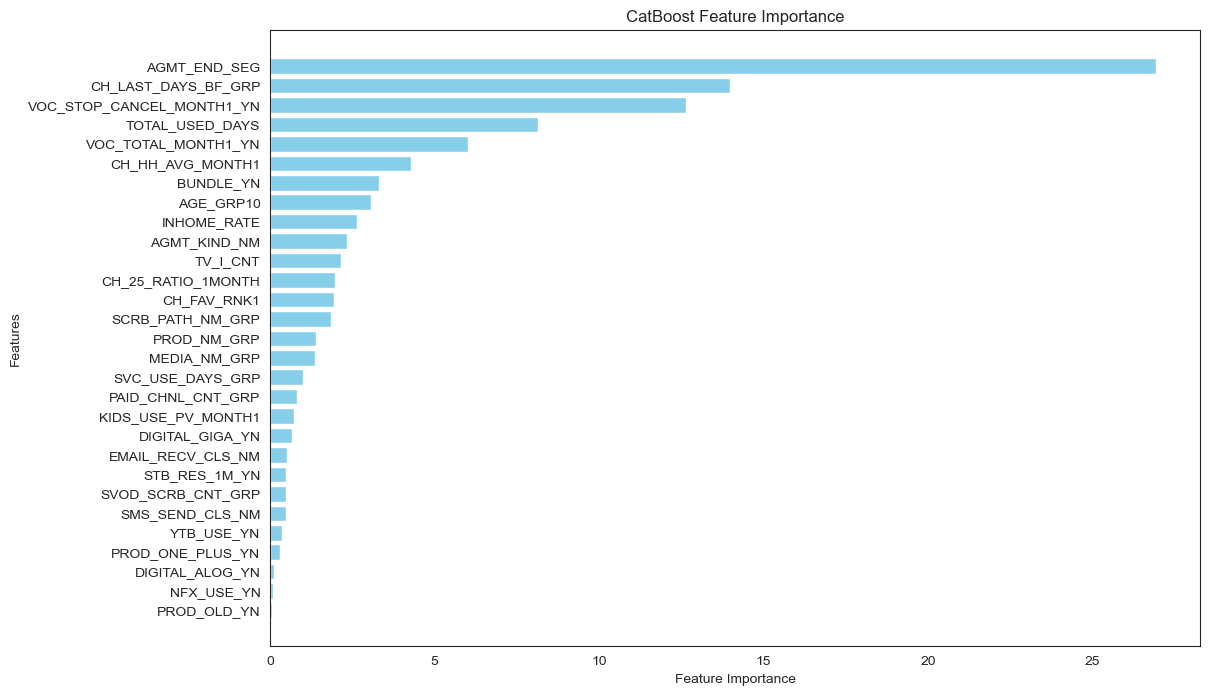

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()


---

### 2. SMOTE-NC 데이터로 CatBoost 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [10]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/smote_modeling/train.csv")
val = pd.read_csv("data/train/smote_modeling/val.csv")
test = pd.read_csv("data/train/smote_modeling/test.csv")

CatBoost 학습

In [11]:
from catboost import CatBoostClassifier

X_train = train.drop(columns=['churn'])
y_train = train['churn']

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

cat_model.fit(X_train, y_train)

0:	learn: 0.6772163	total: 963ms	remaining: 16m 1s
1:	learn: 0.6625557	total: 1.77s	remaining: 14m 42s
2:	learn: 0.6490229	total: 2.46s	remaining: 13m 35s
3:	learn: 0.6368165	total: 3.2s	remaining: 13m 16s
4:	learn: 0.6254101	total: 3.9s	remaining: 12m 57s
5:	learn: 0.6150627	total: 4.54s	remaining: 12m 33s
6:	learn: 0.6051411	total: 5.29s	remaining: 12m 29s
7:	learn: 0.5961778	total: 5.92s	remaining: 12m 14s
8:	learn: 0.5873112	total: 6.56s	remaining: 12m 1s
9:	learn: 0.5801727	total: 7.3s	remaining: 12m 2s
10:	learn: 0.5728916	total: 7.91s	remaining: 11m 50s
11:	learn: 0.5658885	total: 8.58s	remaining: 11m 46s
12:	learn: 0.5593892	total: 9.22s	remaining: 11m 39s
13:	learn: 0.5532760	total: 9.96s	remaining: 11m 41s
14:	learn: 0.5461108	total: 10.7s	remaining: 11m 40s
15:	learn: 0.5410634	total: 11.4s	remaining: 11m 39s
16:	learn: 0.5356905	total: 12.1s	remaining: 11m 38s
17:	learn: 0.5295177	total: 12.9s	remaining: 11m 41s
18:	learn: 0.5255853	total: 13.6s	remaining: 11m 39s
19:	learn

Validation Accuracy: 0.87

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.87      0.93   1941866
           1       0.02      0.44      0.04     13252

    accuracy                           0.87   1955118
   macro avg       0.51      0.65      0.49   1955118
weighted avg       0.99      0.87      0.92   1955118


Confusion Matrix (Validation):
[[1689234  252632]
 [   7422    5830]]


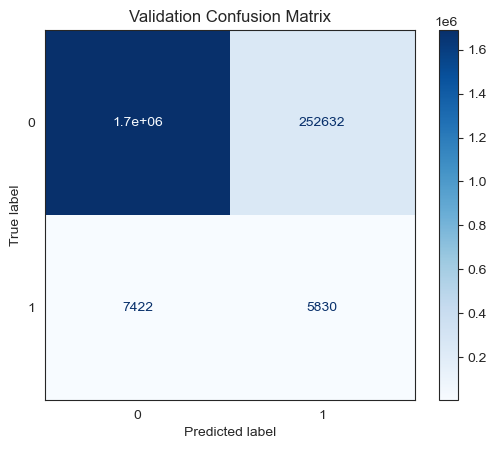

Validation AUC-ROC: 0.72


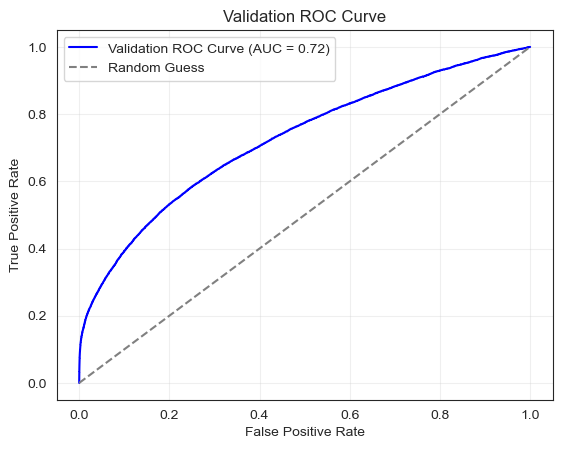

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = cat_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cat_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = cat_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

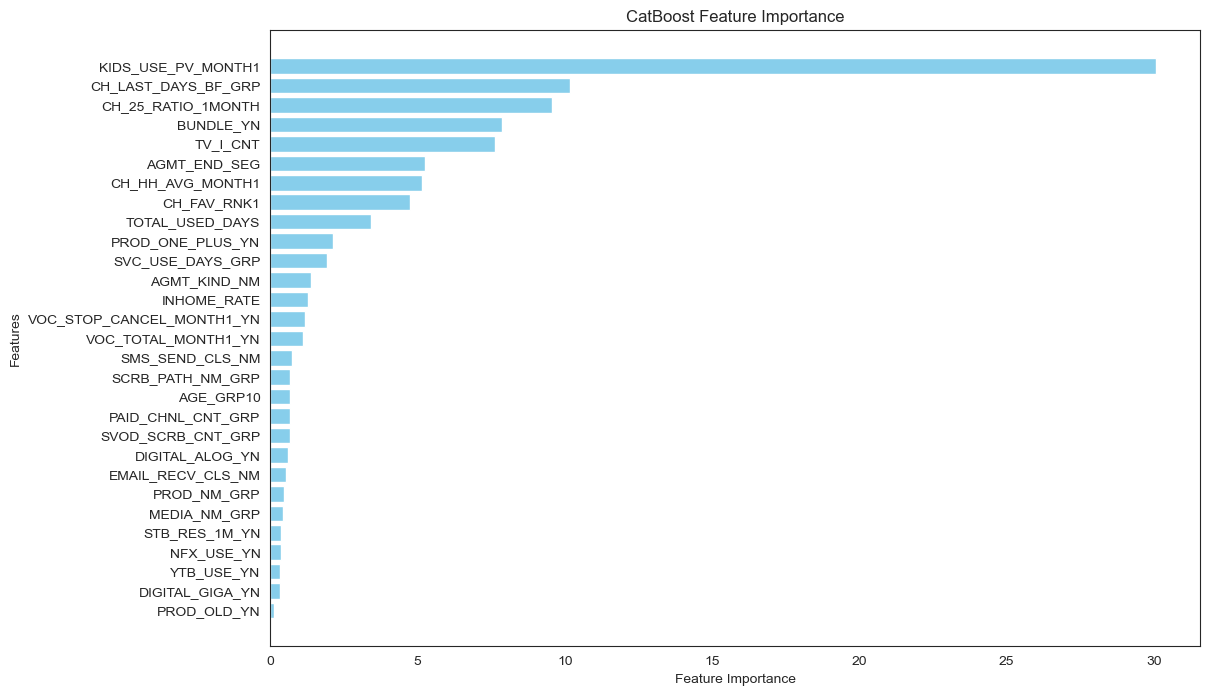

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 3. SMOTE-NC + 랜덤 언더 샘플링 데이터로 CatBoost 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [14]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/smoterandom_modeling/train.csv")
val = pd.read_csv("data/train/smoterandom_modeling/val.csv")
test = pd.read_csv("data/train/smoterandom_modeling/test.csv")

LGBM 학습

In [15]:
from catboost import CatBoostClassifier

X_train = train.drop(columns=['churn'])
y_train = train['churn']

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

cat_model.fit(X_train, y_train)

0:	learn: 0.6770547	total: 331ms	remaining: 5m 30s
1:	learn: 0.6623363	total: 693ms	remaining: 5m 46s
2:	learn: 0.6485005	total: 1.12s	remaining: 6m 12s
3:	learn: 0.6359332	total: 1.54s	remaining: 6m 24s
4:	learn: 0.6241690	total: 1.94s	remaining: 6m 25s
5:	learn: 0.6135144	total: 2.4s	remaining: 6m 36s
6:	learn: 0.6036164	total: 2.76s	remaining: 6m 31s
7:	learn: 0.5941792	total: 3.14s	remaining: 6m 29s
8:	learn: 0.5858367	total: 3.6s	remaining: 6m 36s
9:	learn: 0.5785235	total: 3.98s	remaining: 6m 34s
10:	learn: 0.5708163	total: 4.33s	remaining: 6m 29s
11:	learn: 0.5639946	total: 4.73s	remaining: 6m 29s
12:	learn: 0.5572577	total: 5.15s	remaining: 6m 31s
13:	learn: 0.5499199	total: 5.49s	remaining: 6m 26s
14:	learn: 0.5443061	total: 5.82s	remaining: 6m 21s
15:	learn: 0.5386512	total: 6.27s	remaining: 6m 25s
16:	learn: 0.5326669	total: 6.7s	remaining: 6m 27s
17:	learn: 0.5278390	total: 7.25s	remaining: 6m 35s
18:	learn: 0.5233400	total: 7.64s	remaining: 6m 34s
19:	learn: 0.5195233	tota

Validation Accuracy: 0.89

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.89      0.94   1941866
           1       0.03      0.42      0.05     13252

    accuracy                           0.89   1955118
   macro avg       0.51      0.65      0.49   1955118
weighted avg       0.99      0.89      0.93   1955118


Confusion Matrix (Validation):
[[1729083  212783]
 [   7716    5536]]


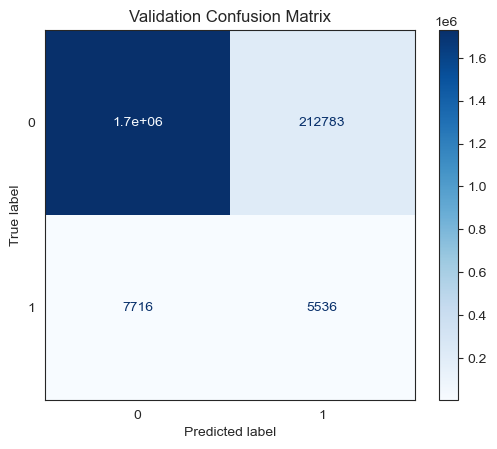

Validation AUC-ROC: 0.73


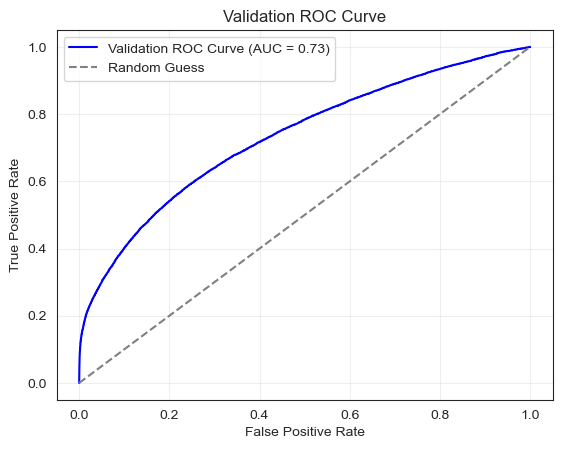

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = cat_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cat_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = cat_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

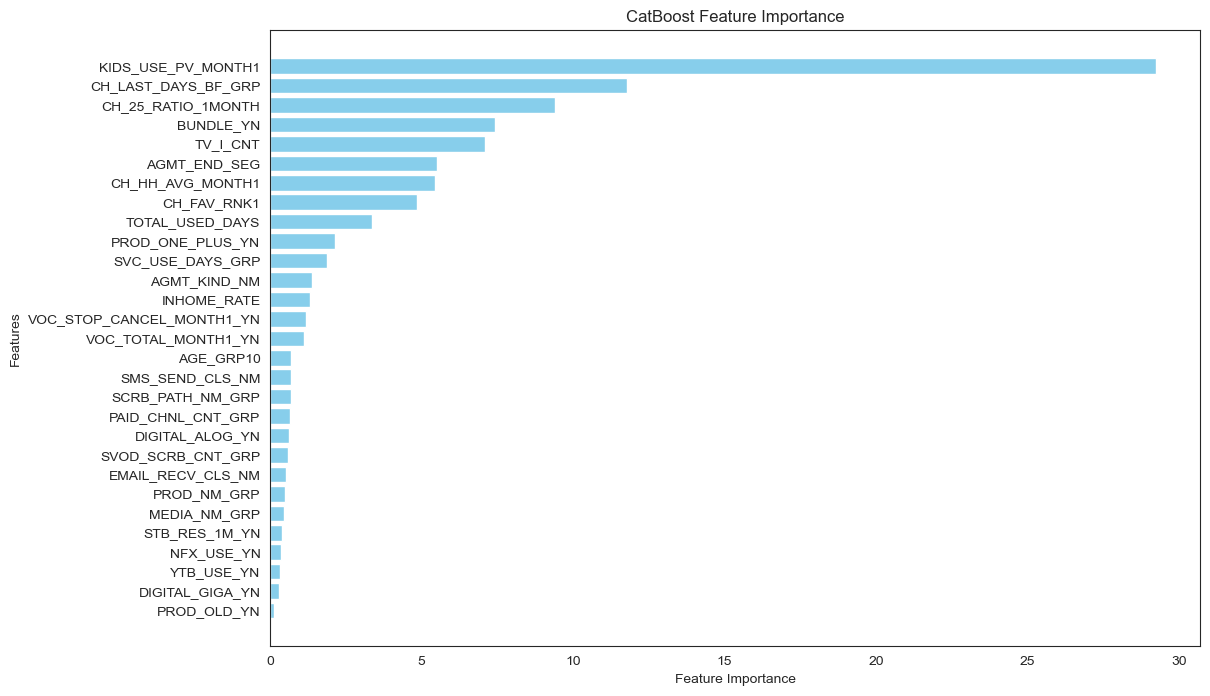

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 4. 가중치로 CatBoost 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [18]:
train = pd.read_csv("data/train/train.csv")
val = pd.read_csv("data/train/validation.csv")
test = pd.read_csv("data/train/test.csv")

In [19]:
val = val.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])
test = test.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])

In [20]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(val['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object
object


In [21]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [22]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'KIDS_USE_PV_MONTH1', 'CH_25_RATIO_1MONTH']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


CatBoost 학습

In [28]:
from catboost import CatBoostClassifier

# 가중치
# scale_pos_weight_value = train['churn'].value_counts()[0] / train['churn'].value_counts()[1]
# print(f"Calculated class weight for churn=1: {scale_pos_weight_value:.2f}")

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42,
    class_weights=[1, 5]
)

cat_model.fit(X_train, y_train)


0:	learn: 0.6667684	total: 370ms	remaining: 6m 9s
1:	learn: 0.6420013	total: 735ms	remaining: 6m 6s
2:	learn: 0.6205947	total: 1.1s	remaining: 6m 6s
3:	learn: 0.6015035	total: 1.43s	remaining: 5m 56s
4:	learn: 0.5837937	total: 1.75s	remaining: 5m 47s
5:	learn: 0.5673922	total: 2.08s	remaining: 5m 44s
6:	learn: 0.5512822	total: 2.48s	remaining: 5m 51s
7:	learn: 0.5372026	total: 2.83s	remaining: 5m 51s
8:	learn: 0.5243469	total: 3.24s	remaining: 5m 56s
9:	learn: 0.5135546	total: 3.57s	remaining: 5m 53s
10:	learn: 0.5021657	total: 3.89s	remaining: 5m 49s
11:	learn: 0.4922484	total: 4.32s	remaining: 5m 55s
12:	learn: 0.4824539	total: 4.72s	remaining: 5m 58s
13:	learn: 0.4734438	total: 5.2s	remaining: 6m 6s
14:	learn: 0.4653205	total: 5.62s	remaining: 6m 9s
15:	learn: 0.4573853	total: 6.03s	remaining: 6m 10s
16:	learn: 0.4502854	total: 6.4s	remaining: 6m 10s
17:	learn: 0.4434479	total: 6.86s	remaining: 6m 14s
18:	learn: 0.4375123	total: 7.3s	remaining: 6m 16s
19:	learn: 0.4312822	total: 7.6

Validation Accuracy: 0.71

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.71      0.83   1941866
           1       0.01      0.61      0.03     13252

    accuracy                           0.71   1955118
   macro avg       0.51      0.66      0.43   1955118
weighted avg       0.99      0.71      0.83   1955118


Confusion Matrix (Validation):
[[1382940  558926]
 [   5172    8080]]


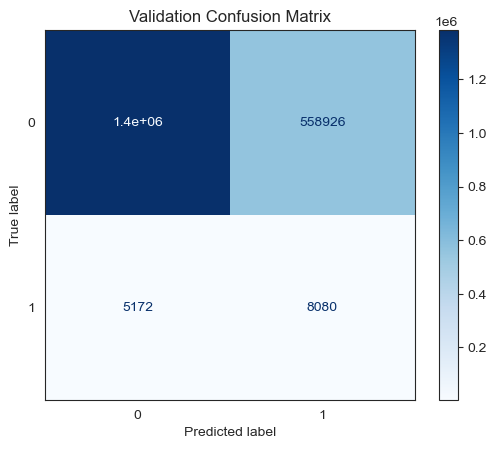

Validation AUC-ROC: 0.72


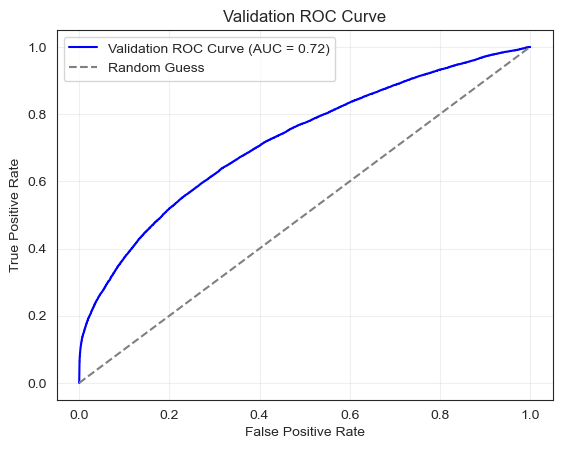

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = cat_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cat_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = cat_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


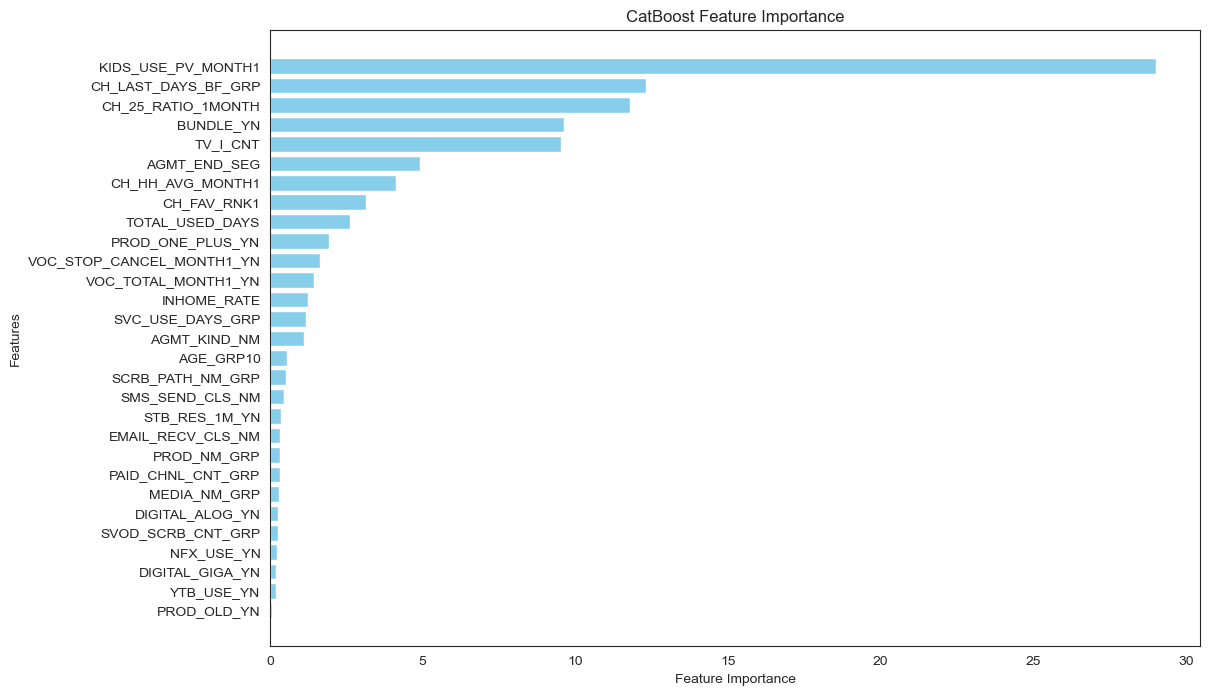

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

#### 결론
CatBoost는 랜덤 언더를 했을 때, 가장 좋다

### 📌 CatBoost 성능 비교 (Sampling 기법별)

| 샘플링 기법             | Accuracy | 1의 Recall | ROC-AUC |
|------------------------|----------|-----------|---------|
| <span style="color:red;">**랜덤 언더샘플링**</span>     | 0.80     | 0.72      | 0.84    |
| **SMOTE**              | 0.87     | 0.44      | 0.72    |
| **SMOTE + 랜덤 언더샘플링** | 0.89     | 0.42      | 0.73    |
| **가중치 조정**      | 0.71     | 0.61      | 0.72    |